# ORNL VENUS Neutron Transmission Analysis: Hafnium Multi-Isotope System

## Instrument: VENUS (Versatile Neutron Imaging Station)
## Facility: Oak Ridge National Laboratory

In [1]:
from dotenv import load_dotenv
load_dotenv('../../../.envrc')

True

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Environment Configuration

In [3]:
# Verify resolution function environment variable
resolution_file_path = Path(os.environ.get('VENUS_RES_FUNC', ''))
if not resolution_file_path.exists():
    raise FileNotFoundError(f"Resolution file not found at VENUS_RES_FUNC: {resolution_file_path}")

# VENUS data paths
ipts_path = "/SNS/VENUS/IPTS-35945"
nexus_path = f"{ipts_path}/nexus"
autoreduce_base = f"{ipts_path}/shared/autoreduce/mcp/images"

# Analysis directories
working_dir = "./hf_analysis"
os.makedirs(working_dir, exist_ok=True)
spectra_dir = f"{working_dir}/spectra"
os.makedirs(spectra_dir, exist_ok=True)
twenty_dir = f"{working_dir}/twenty"
os.makedirs(twenty_dir, exist_ok=True)
sammy_working = Path(working_dir) / "sammy_working"
sammy_output = Path(working_dir) / "sammy_output"
sammy_working.mkdir(exist_ok=True)
sammy_output.mkdir(exist_ok=True)

## Data Processing

In [4]:
from pleiades.processing.normalization import normalization
from pleiades.processing import Roi, Facility

open_beam_folder = f"{autoreduce_base}/Run_8045"
sample_folders = [
    f"{autoreduce_base}/Run_8046"
]

In [5]:
transmissions = normalization(
    list_sample_folders=sample_folders,
    list_obs_folders=[open_beam_folder],
    nexus_path=nexus_path,
    facility=Facility.ornl,
    combine_mode=False,
    pc_uncertainty=0.005,
    output_folder=os.path.join(working_dir, "spectra"),
)

2025-09-25 16:21:26 | INFO     | pleiades.processing.normalization:normalization:91 - Using ORNL-specific normalization
olefile module not found
/SNS/users/8cz/github.com/PLEIADES/.pixi/envs/default/lib/python3.11/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-09-25 16:21:27 | INFO     | pleiades.processing.normalization_ornl:normalization_ornl:199 - Loading 1 sample folders
2025-09-25 16:21:27 | INFO     | pleiades.utils.load:load:21 - loading 4367 files with extension .tif
2025-09-25 16:22:16 | DEBUG    | pleiades.processing.helper_ornl:load_spectra_file:42 - Found spectra file: Run_8046_20250424_April23_2025_MCP_TPX_Foil_Hf_1_6C_Resonance_0001_2609116_Spectra.txt
2025-09-25 16:22:16 | INFO     | pleiades.processing.helper_orn

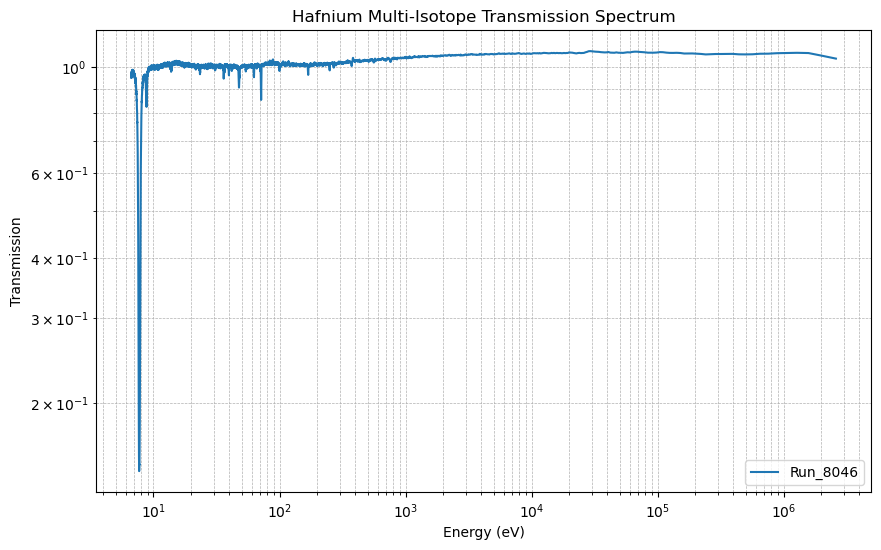

In [6]:
# Transmission spectrum visualization
fig, ax = plt.subplots(figsize=(10, 6))
for transmission in transmissions:
    label = transmission.metadata.get("sample_folder", "Unknown").split("/")[-1]
    ax.plot(transmission.energy, transmission.transmission, label=label)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Transmission")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both", ls="--", lw=0.5)
ax.legend()
ax.set_title("Hafnium Multi-Isotope Transmission Spectrum")
plt.show()

## SAMMY Data Format Conversion

In [7]:
from pleiades.sammy.io.data_manager import convert_csv_to_sammy_twenty, validate_sammy_twenty_format

input_dir = Path(spectra_dir)
output_dir = Path(twenty_dir)

csv_files = list(input_dir.glob("*_transmission.txt"))
print(f"Converting {len(csv_files)} transmission files")

for csv_file in csv_files:
    twenty_file = output_dir / csv_file.name.replace(".txt", ".twenty")
    convert_csv_to_sammy_twenty(csv_file, twenty_file)
    if validate_sammy_twenty_format(twenty_file):
        print(f"Converted: {twenty_file.name}")

2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.data_manager:convert_csv_to_sammy_twenty:53 - Converting hf_analysis/spectra/Run_8046_transmission.txt to SAMMY twenty format: hf_analysis/twenty/Run_8046_transmission.twenty
2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.data_manager:convert_csv_to_sammy_twenty:123 - Converted 4367 data points to twenty format
2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.data_manager:validate_sammy_twenty_format:163 - File hf_analysis/twenty/Run_8046_transmission.twenty is valid SAMMY twenty format


Converting 1 transmission files
Converted: Run_8046_transmission.twenty


## Multi-Isotope SAMMY Configuration

Natural hafnium isotopic composition:
- Hf-174: 0.16%
- Hf-176: 5.26%
- Hf-177: 18.60%
- Hf-178: 27.28%
- Hf-179: 13.62%
- Hf-180: 35.08%

In [8]:
from pleiades.sammy.io.json_manager import JsonManager

json_manager = JsonManager()
json_path = json_manager.create_json_config(
    isotopes=["Hf-174", "Hf-176", "Hf-177", "Hf-178", "Hf-179", "Hf-180"],
    abundances=[0.0016, 0.0526, 0.1860, 0.2728, 0.1362, 0.3508],
    working_dir=working_dir,
    custom_global_settings={
        "forceRMoore": "yes",
        "purgeSpinGroups": "yes",
        "fudge": "0.7"
    }
)

print(f"JSON configuration: {json_path}")
endf_files = [f for f in os.listdir(working_dir) if f.endswith('.par')]
print(f"ENDF files: {len(endf_files)}")
for f in sorted(endf_files):
    print(f"  {f}")

2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.json_manager:__init__:165 - JsonManager initialized with Pydantic v2 models
2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.json_manager:create_json_config:214 - Creating SAMMY workspace for 6 isotopes: ['Hf-174', 'Hf-176', 'Hf-177', 'Hf-178', 'Hf-179', 'Hf-180']
2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.json_manager:create_json_config:215 - Working directory: hf_analysis
2025-09-25 16:23:07 | INFO     | pleiades.sammy.io.json_manager:create_json_config:218 - Step 1: Staging ENDF files...
2025-09-25 16:23:07 | INFO     | pleiades.nuclear.isotopes.manager:get_isotope_info:167 - Getting isotope parameters for Hf-174
2025-09-25 16:23:07 | INFO     | pleiades.nuclear.isotopes.manager:get_file_path:75 - Searching for mass.mas20 in cached files for FileCategory.ISOTOPES: {PosixPath('/SNS/users/8cz/github.com/PLEIADES/src/pleiades/nuclear/isotopes/files/neutrons.list'), PosixPath('/SNS/users/8cz/github.com/PLEIADES/src/pleiades/nu

JSON configuration: hf_analysis/config.json
ENDF files: 6
  072-Hf-174.B-VIII.0.par
  072-Hf-176.B-VIII.0.par
  072-Hf-177.B-VIII.0.par
  072-Hf-178.B-VIII.0.par
  072-Hf-179.B-VIII.0.par
  072-Hf-180.B-VIII.0.par


In [9]:
from pleiades.sammy.io.inp_manager import InpManager

hf_material_props = {
    'element': 'Hf',
    'mass_number': 178,  # Weighted average
    'density_g_cm3': 13.31,
    'thickness_mm': 0.05,
    'atomic_mass_amu': 178.49,  # Weighted average
    'abundance': 1.0,
    'min_energy': 1.0,
    'max_energy_eV': 200.0,
    'temperature_K': 293.6
}

inp_file = Path(working_dir) / "hf_fitting.inp"
InpManager.create_multi_isotope_inp(
    inp_file,
    title="Hafnium multi-isotope neutron transmission analysis - VENUS IPTS-35945",
    material_properties=hf_material_props,
    resolution_file_path=resolution_file_path
)

print(f"INP file: {inp_file}")

2025-09-25 16:23:08 | INFO     | pleiades.utils.logger:__init__:145 - logging initialized...
2025-09-25 16:23:08 | INFO     | pleiades.sammy.io.inp_manager:create_multi_isotope_inp:480 - Successfully wrote multi-isotope SAMMY input file to hf_analysis/hf_fitting.inp


INP file: hf_analysis/hf_fitting.inp


In [10]:
from pleiades.sammy.backends.local import LocalSammyRunner
from pleiades.sammy.config import LocalSammyConfig
from pleiades.sammy.interface import SammyFilesMultiMode

data_file = Path(twenty_dir) / "Run_8046_transmission.twenty"

files = SammyFilesMultiMode(
    input_file=inp_file,
    json_config_file=Path(json_path),
    data_file=data_file,
    endf_directory=Path(working_dir)
)

config = LocalSammyConfig(
    sammy_executable=Path("/SNS/software/sammy/bin/sammy"),
    working_dir=sammy_working,
    output_dir=sammy_output
)

runner = LocalSammyRunner(config)

## Multi-Isotope SAMMY Execution

In [11]:
print("Executing multi-isotope SAMMY fitting")
runner.prepare_environment(files)
result = runner.execute_sammy(files)

print(f"Execution status: {result.success}")
print(f"Runtime: {result.runtime_seconds:.2f} s")

if result.error_message:
    print(f"Error: {result.error_message[:200]}")

runner.collect_outputs(result=result)
runner.cleanup()

2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.backends.local:prepare_environment:45 - Validating input files
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.backends.local:prepare_environment:50 - Performing JSON-ENDF mapping validation
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.backends.local:_validate_json_endf_mapping:100 - JSON-ENDF validation passed: 6 ENDF files verified
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.backends.local:prepare_environment:54 - Moving files to working directory
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.interface:move_to_working_dir:214 - Moving JSON mode files to working directory: hf_analysis/sammy_working
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.interface:move_to_working_dir:253 - Symlinked ENDF file: 072-Hf-177.B-VIII.0.par
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.interface:move_to_working_dir:253 - Symlinked ENDF file: 072-Hf-180.B-VIII.0.par
2025-09-25 16:23:08 | DEBUG    | pleiades.sammy.interface:move_to_working_dir:

Executing multi-isotope SAMMY fitting


2025-09-25 16:23:11 | INFO     | pleiades.sammy.backends.local:execute_sammy:156 - SAMMY execution completed successfully for b8a922b7-1097-4b31-be67-027b6fa9f623
2025-09-25 16:23:11 | INFO     | pleiades.sammy.interface:collect_outputs:432 - Collecting outputs for execution b8a922b7-1097-4b31-be67-027b6fa9f623
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.interface:collect_outputs:443 - Found known output file: SAMNDF.PAR
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.interface:collect_outputs:443 - Found known output file: SAMMY.ODF
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.interface:collect_outputs:443 - Found known output file: SAMNDF.INP
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.interface:collect_outputs:443 - Found known output file: SAMMY.LST
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.interface:collect_outputs:443 - Found known output file: SAMMY.IO
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.interface:collect_outputs:443 - Found known output file: SAMMY.

Execution status: True
Runtime: 3.39 s


## Results Analysis

In [12]:
from pleiades.sammy.results.manager import ResultsManager

lpt_file_path = sammy_output / "SAMMY.LPT"
lst_file_path = sammy_output / "SAMMY.LST"

results_manager = ResultsManager(lpt_file_path=lpt_file_path, lst_file_path=lst_file_path)
data = results_manager.get_data()

print(f"Energy range: {data.energy.min():.3e} - {data.energy.max():.3e} eV")
print(f"Data points: {len(data.energy)}")

2025-09-25 16:23:11 | INFO     | pleiades.sammy.io.lpt_manager:process_lpt_file:479 - Successfully read the file: hf_analysis/sammy_output/SAMMY.LPT
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.io.lpt_manager:process_lpt_file:490 - Split LPT content into 3 blocks.
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.io.lpt_manager:extract_isotope_info:116 - Extracting isotope information...
2025-09-25 16:23:11 | INFO     | pleiades.sammy.io.lpt_manager:extract_results_from_string:415 - Isotope results not found.
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.io.lpt_manager:extract_radius_info:189 - Extracting radius information...
2025-09-25 16:23:11 | INFO     | pleiades.sammy.io.lpt_manager:extract_results_from_string:418 - Radius results not found.
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.io.lpt_manager:extract_broadening_info:261 - Extracting broadening information...
2025-09-25 16:23:11 | DEBUG    | pleiades.sammy.io.lpt_manager:extract_normalization_info:328 - Extracting no

Energy range: 6.673e+00 - 1.999e+02 eV
Data points: 3575


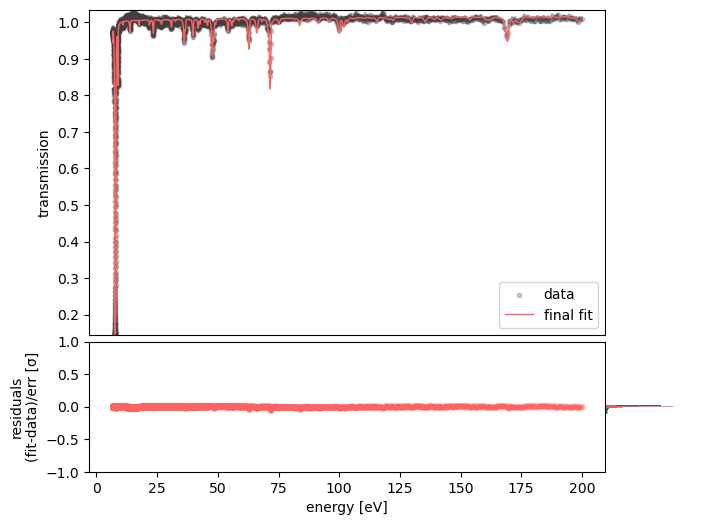

In [13]:
results_manager.plot_transmission(
    show_diff = True,
    plot_uncertainty = True,
)

## Multi-Isotope Fitting Quality Metrics

In [14]:
if results_manager.run_results.fit_results:
    print(f"Fit iterations: {len(results_manager.run_results.fit_results)}")
    
    for i, fit_result in enumerate(results_manager.run_results.fit_results):
        print(f"\nIteration {i+1}:")
        
        chi_sq = fit_result.get_chi_squared_results()
        if chi_sq.chi_squared is not None:
            print(f"  Chi-squared: {chi_sq.chi_squared:.4f}")
            print(f"  Data points: {chi_sq.dof}")
            print(f"  Reduced chi-squared: {chi_sq.reduced_chi_squared:.6f}")
        
        physics = fit_result.get_physics_data()
        if hasattr(physics, 'broadening_parameters'):
            broadening = physics.broadening_parameters
            if hasattr(broadening, 'thick') and broadening.thick is not None:
                print(f"  Number density: {broadening.thick:.6e} atoms/barn-cm")
                print(f"  Temperature: {broadening.temp:.2f} K")
        
        # Multi-isotope abundances
        nuclear = fit_result.get_nuclear_data()
        if hasattr(nuclear, 'isotopes') and nuclear.isotopes:
            print("\n  Isotopic abundances:")
            hf_isotopes = ["Hf-174", "Hf-176", "Hf-177", "Hf-178", "Hf-179", "Hf-180"]
            natural_abundances = [0.0016, 0.0526, 0.1860, 0.2728, 0.1362, 0.3508]
            
            for j, isotope in enumerate(nuclear.isotopes):
                if j < len(hf_isotopes) and hasattr(isotope, 'abundance'):
                    fitted = isotope.abundance
                    natural = natural_abundances[j]
                    ratio = fitted / natural if natural > 0 else 0
                    print(f"    {hf_isotopes[j]}: fitted={fitted:.6f}, natural={natural:.4f}, ratio={ratio:.3f}")

    # Final results
    if len(results_manager.run_results.fit_results) > 0:
        final_fit = results_manager.run_results.fit_results[-1]
        final_chi = final_fit.get_chi_squared_results()
        final_phys = final_fit.get_physics_data()
        
        print("\nFinal multi-isotope fit results:")
        if final_chi.reduced_chi_squared:
            print(f"  Reduced chi-squared: {final_chi.reduced_chi_squared:.6f}")
        if hasattr(final_phys, 'broadening_parameters'):
            if hasattr(final_phys.broadening_parameters, 'thick'):
                print(f"  Number density: {final_phys.broadening_parameters.thick:.6e} atoms/barn-cm")

Fit iterations: 3

Iteration 1:
  Chi-squared: 721159.0000
  Data points: 3575
  Reduced chi-squared: 201.723000
  Number density: 2.250000e-04 atoms/barn-cm
  Temperature: 293.60 K

Iteration 2:
  Chi-squared: 9205.0400
  Data points: 3575
  Reduced chi-squared: 2.574840
  Number density: 1.591200e-04 atoms/barn-cm
  Temperature: 293.60 K

Iteration 3:
  Chi-squared: 4017.0300
  Data points: 3575
  Reduced chi-squared: 1.123640
  Number density: 1.589900e-04 atoms/barn-cm
  Temperature: 293.60 K

Final multi-isotope fit results:
  Reduced chi-squared: 1.123640
  Number density: 1.589900e-04 atoms/barn-cm
